<a href="https://colab.research.google.com/github/rcdavid1/dummy/blob/main/Udated_R_C_David_of_company25_expl_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Dictionary

| Field Name | Description |
| :--- | :--- |
| **counterParty** | Name of the customer or business partner |
| **counterPartyIdentifier** | Unique identifier code for the customer |
| **typeOfSale** | Indicates whether the transaction is a "Sale" or "Return" |
| **documentNumber** | Invoice number |
| **invoiceDate** | Date when the invoice was created |
| **referenceOrder** | Sales order reference |
| **productNumber** | Product identifier |
| **productDescription** | Text description of the product |
| **productGroup** | Product group (highest level of grouping) |
| **productLine** | Product line |
| **vendorProductNumber** | Vendor's reference number for the product |
| **manufacturer** | Name of the product manufacturer |
| **unitOfMeasure** | Standardized unit of measure |
| **quantity** | Amount of product sold, rounded to 2 decimal places |
| **unit_price** | Price per unit, rounded to 2 decimal places |
| **unit_price_currency** | Currency code for the price (e.g., USD) |
| **total** | Calculated total value (quantity × unit price), rounded to 2 decimal places |
| **shipToIdentifier** | Ship-to identifier |
| **shipToName** | Name of the ship-to location |
| **shipToState** | State code of shipping destination |
| **shipToCounty** | Country code of shipping destination |
| **shipFromIdentifier** | Plant/terminal identifier where product shipped from |
| **shipFromName** | Name of the shipping origin facility |
| **shipFromState** | State code of shipping origin |
| **shipFromCounty** | Country code of shipping origin |

# Client's Description of Data and Request
* The dataset comprises sales information across all product groups for the calendar years 2021 to 2023.
* It includes details on product groups and product lines, facilitating product categorization. Although the data is anonymized, it effectively illustrates the seasonality of the agriculture cycle across all product groups.
* Request: Some explorations into how certain product groups or lines sell more in certain parts of the season would be interesting, and it may be worth trying to trend a 4th year of that data based on the result set.

# Imports

In [ ]:
!pip install -q gdown

import gdown
import requests
from cryptography.fernet import Fernet
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.pbkdf2 import PBKDF2HMAC
import base64
import getpass
import hashlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# Display Options

In [ ]:
# set to avoid scientific notation in numerics
pd.set_option('display.float_format', '{:.2f}'.format)

## Download and Decrypt Data

In [8]:
file_id = "1V2S-lUrFxcAJze_opSaWZrfk3_6LBdJL"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "encrypted_data.enc", quiet=False)


# Prompt for the password
password = getpass.getpass('Enter the password to decrypt the file: ').encode()

# Read the encrypted file
with open('encrypted_data.enc', 'rb') as encrypted_file:
    encrypted_data_with_salt = encrypted_file.read()

# Extract the salt (first 16 bytes)
salt = encrypted_data_with_salt[:16]
encrypted_data = encrypted_data_with_salt[16:]

# Regenerate the key using the password and salt
kdf = PBKDF2HMAC(
    algorithm=hashes.SHA256(),
    length=32,
    salt=salt,
    iterations=480000,
)
key = base64.urlsafe_b64encode(kdf.derive(password))

# Create a Fernet instance
fernet = Fernet(key)

try:
    # Decrypt the data
    decrypted_data = fernet.decrypt(encrypted_data)

    # Save the decrypted data to a file
    with open('decrypted_data_file.csv', 'wb') as decrypted_file:
        decrypted_file.write(decrypted_data)

    print("File decrypted successfully and saved as 'decrypted_data_file.csv'")
except Exception as e:
    print(f"An error occurred during decryption: {e}")
    print("Please check if the password is correct.")


FILENAME = 'encrypted_data.enc'

try:
    with open(FILENAME, 'rb') as f:
        bytes = f.read()
        readable_hash = hashlib.sha256(bytes).hexdigest()
        print(f"The SHA-256 hash of {FILENAME} is:")
        print(readable_hash)
except FileNotFoundError:
    print(f"Error: Could not find the file named '{FILENAME}'. Please check the file name and location.")

Downloading...
From (original): https://drive.google.com/uc?id=1V2S-lUrFxcAJze_opSaWZrfk3_6LBdJL
From (redirected): https://drive.google.com/uc?id=1V2S-lUrFxcAJze_opSaWZrfk3_6LBdJL&confirm=t&uuid=628abfdb-71f6-449a-a2ef-659f587905b2
To: /content/encrypted_data.enc
100%|██████████| 282M/282M [00:03<00:00, 72.8MB/s]


File decrypted successfully and saved as 'decrypted_data_file.csv'
The SHA-256 hash of encrypted_data.enc is:
41b8ce91d89ef5ffac1e754f8b0e8787d158d25d9fd470ad9836ba9462050897


# Create Dataframe

## General Clean Up and Fix Canadian Issue

In [9]:
df = pd.read_csv(r'/content/decrypted_data_file.csv')

df.columns = df.columns.str.lower()

# shiptocounty and shipfromcounty, are monotonic (always US) and are dropped
df = df.drop(columns=['shiptocounty', 'shipfromcounty'])

# convert invoicedate to datetime, there is no hours, minutes, seconds, so only the date is extracted
df['invoicedate'] = pd.to_datetime(df['invoicedate'])

# we have many columns with redudant text
redundant_text_columns = ['counterpartyidentifier', 'productdescription', 'productgroup', 'productline', 'shiptoname', 'shipfromname']

for col in redundant_text_columns:
  # Use .str.replace with a regular expression to remove non-numeric characters
  df[col] = df[col].str.replace(r'\D', '', regex=True)

  # Use pd.to_numeric to convert the cleaned strings to integers
  # errors='coerce' will turn any values that still can't be converted into NaN (Not a Number)
  df[col] = pd.to_numeric(df[col], errors='coerce')


# Finally, if you need the columns to be strictly of integer type (not float), you can use .astype(int)
df[redundant_text_columns] = df[redundant_text_columns].astype(int)

df.head()


,counterparty,counterpartyidentifier,typeofsale,documentnumber,invoicedate,referenceorder,productnumber,productdescription,productgroup,productline,...,unit_price,unit_price_currency,total,shiptoidentifier,shiptoname,shiptostate,shipfromidentifier,shipfromname,shipfromstate,vendorproductnumber
0,79120621,1,Sale,77075531,2023-09-01,75570995,48491034,1,1,1,...,3.97,USD,4112.92,39917128,1,IL,87037419,1,IL,NaN
1,79120621,1,Sale,49466313,2023-01-11,37922588,51939548,2,1,1,...,4.04,USD,600.91,39917128,1,IL,87037419,1,IL,NaN
2,79120621,1,Sale,86778092,2021-03-24,76042445,48491034,1,1,1,...,2.58,USD,1813.74,39917128,1,IL,87037419,1,IL,NaN
3,79120621,1,Sale,16322175,2021-04-01,82692278,69498202,3,1,2,...,2.97,USD,663.74,39917128,1,IL,87037419,1,IL,NaN
4,79120621,1,Sale,56780298,2022-04-04,27661768,48491034,1,1,1,...,4.84,USD,3402.52,39917128,1,IL,87037419,1,IL,NaN


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032873 entries, 0 to 1032872
Data columns (total 22 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   counterparty            1032873 non-null  int64         
 1   counterpartyidentifier  1032873 non-null  int64         
 2   typeofsale              1032873 non-null  object        
 3   documentnumber          1032873 non-null  int64         
 4   invoicedate             1032873 non-null  datetime64[ns]
 5   referenceorder          1032873 non-null  int64         
 6   productnumber           1032873 non-null  int64         
 7   productdescription      1032873 non-null  int64         
 8   productgroup            1032873 non-null  int64         
 9   productline             1032873 non-null  int64         
 10  unitofmeasure           1032873 non-null  object        
 11  quantity                1032873 non-null  float64       
 12  unit_price    

In [11]:
# resolving the single issues using CAD by coverting to USD
cad_mask = df.unit_price_currency == 'CAD'
print(f'# of rows with CAD: {cad_mask.sum()}')
cad_value = df.loc[cad_mask, 'unit_price'].values[0]
cad_date = df.loc[cad_mask, 'invoicedate'].values[0]

print(f'Canadian Sale\tAmount in Canadian: {cad_value}\tDate of Sale: {cad_date}')
print(f'CAD/USD Rate on 2021-2-5: 1 CAD = 078351')
df.loc[cad_mask, 'unit_price'] = df.loc[cad_mask, 'unit_price'] * .78351  # the actual coversion is done here, the rest is just for display purposes
print(f'Amount after conversion: {df.loc[cad_mask, 'unit_price'].values[0]}')

print('Dropping unit price currency as all values are now in USD.')
df = df.drop(columns = 'unit_price_currency')

# of rows with CAD: 1
Canadian Sale	Amount in Canadian: 2505.18	Date of Sale: 2021-02-05T00:00:00.000000000
CAD/USD Rate on 2021-2-5: 1 CAD = 078351
Amount after conversion: 1962.8335818
Dropping unit price currency as all values are now in USD.


## Documenting and Dropping Duplicate Rows

In [12]:
# Count all duplicate rows
num_duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows (considering all columns): {num_duplicate_rows}")


Number of duplicate rows (considering all columns): 31


In [13]:
# Show all rows that are duplicates (including their first occurrence)
all_duplicate_rows = df[df.duplicated(keep=False)]
print("\nAll duplicate rows (including first occurrence):")
all_duplicate_rows.head(6)


All duplicate rows (including first occurrence):


,counterparty,counterpartyidentifier,typeofsale,documentnumber,invoicedate,referenceorder,productnumber,productdescription,productgroup,productline,...,quantity,unit_price,total,shiptoidentifier,shiptoname,shiptostate,shipfromidentifier,shipfromname,shipfromstate,vendorproductnumber
119559,91770059,10,Sale,73795528,2021-08-03,50004400,53693099,22,1,1,...,1976.54,2.98,5890.09,27830002,291,IL,61313682,75,IL,NaN
119560,91770059,10,Sale,73795528,2021-08-03,50004400,53693099,22,1,1,...,1976.54,2.98,5890.09,27830002,291,IL,61313682,75,IL,NaN
141592,63404597,22,Sale,61708470,2021-08-03,19907554,28576883,11,1,1,...,395.16,3.04,1201.29,45094099,36,IL,55646279,13,IA,NaN
141593,63404597,22,Sale,61708470,2021-08-03,19907554,28576883,11,1,1,...,395.16,3.04,1201.29,45094099,36,IL,55646279,13,IA,NaN
141594,63404597,22,Sale,61708470,2021-08-03,89702875,28576883,11,1,1,...,4795.94,2.12,10167.39,45094099,36,IL,55646279,13,IA,NaN
141595,63404597,22,Sale,61708470,2021-08-03,89702875,28576883,11,1,1,...,4795.94,2.12,10167.39,45094099,36,IL,55646279,13,IA,NaN


In [14]:
# Drop duplicates
df = df.drop_duplicates()

## Convience Columns, Creating Smaller Df

In [15]:
columns_of_interest = ['quantity', 'unit_price', 'total']
df['month'] = df.invoicedate.dt.month
df['year'] = df.invoicedate.dt.year
df['day'] = df.invoicedate.dt.day


In [16]:
# the plots are very slow because of the size of the datframe
# lets speed things up by plotting with a random subsample
# once we decide what plots we want we will use the full dataframe

# Create a smaller DataFrame with 25% of the rows

df_sub = df.sample(frac = 0.25, random_state = 42)

print(f"Original DataFrame length: {len(df)}")
print(f"Subsampled DataFrame length: {len(df_sub)}")

# create a further subset, that only looks sales/returns separately
sub_sale_mask = df_sub.typeofsale == 'Sale'
df_sub_sale = df_sub[sub_sale_mask]
df_sub_return = df_sub[~sub_sale_mask]

Original DataFrame length: 1032842
Subsampled DataFrame length: 258210


## Distributions

In [17]:
df.nunique()

,0
counterparty,6062
counterpartyidentifier,116
typeofsale,2
documentnumber,824107
invoicedate,1092
referenceorder,996151
productnumber,70415
productdescription,1899
productgroup,14
productline,48


In [ ]:
for col in df.nunique()[df.nunique() < 40].index:
  print(f'{col} values: {sorted(df[col].unique())}')

In [ ]:
for type in df.typeofsale.unique():
  if type == 'Sale':
    for col in columns_of_interest:
      df_temp = df[df.typeofsale == type]
      # sns.violinplot(data=df_temp, y = col, log_scale = True)
      # plt.show()
      print(df_temp[col].value_counts(ascending=False).head(20))
      print()

quantity
0.74       89024
1.48       18218
2.96        9840
2.22        9249
3.70        9067
740.00      9009
7.40        8570
37.00       8360
4.44        7854
5550.00     7430
1480.00     7080
14.80       7074
18.50       6917
74.00       6756
8.88        6116
5624.00     6076
370.00      5456
185.00      4849
2220.00     4791
22.20       4673
Name: count, dtype: int64

unit_price
1.35      10903
29.73      9542
2.70       6876
24.32      4833
3.04       3241
5.41       2987
3.38       2893
2.97       2858
3.11       2723
2.91       2708
2.95       2606
2.94       2582
2.96       2570
2.99       2497
3.45       2477
3.24       2439
2.98       2420
2.93       2398
3.02       2387
133.78     2380
Name: count, dtype: int64

total
22.00     3593
1.00      2770
2.00      2597
99.00     2381
10.00     1971
18.00     1752
100.00    1660
4.00      1496
44.00     1489
3.00      1351
75.00      966
66.00      913
50.00      776
35.99      739
674.88     729
9.99       714
5.00       700
25.00

In [ ]:
df.groupby(by=['unitofmeasure', 'typeofsale'])['quantity'].agg(['count', 'mean', 'median', 'min', 'max']).reset_index().sort_values(['typeofsale','count'], ascending=False)

,unitofmeasure,typeofsale,count,mean,median,min,max
22,GAL,Sale,610187,3252.05,2631.44,0.01,2331000.00
17,EA,Sale,150387,93.87,0.74,0.02,249807.72
47,TON,Sale,142427,30.09,16.31,0.00,12658.55
24,LB,Sale,31406,1007.65,148.00,0.01,33211.20
3,BAG,Sale,20013,80.11,16.28,0.74,3037.70
1,ACRE,Sale,3550,343.40,0.74,0.09,46489.76
12,CASE,Sale,2743,3.18,1.48,0.15,225.70
30,OZ,Sale,1326,1581.25,479.52,7.40,49728.00
36,PAK,Sale,1276,4.89,1.48,0.68,370.00
41,QT,Sale,1161,23.94,8.88,0.74,532.80


# Exploratory Plots

### Plotting by All Years

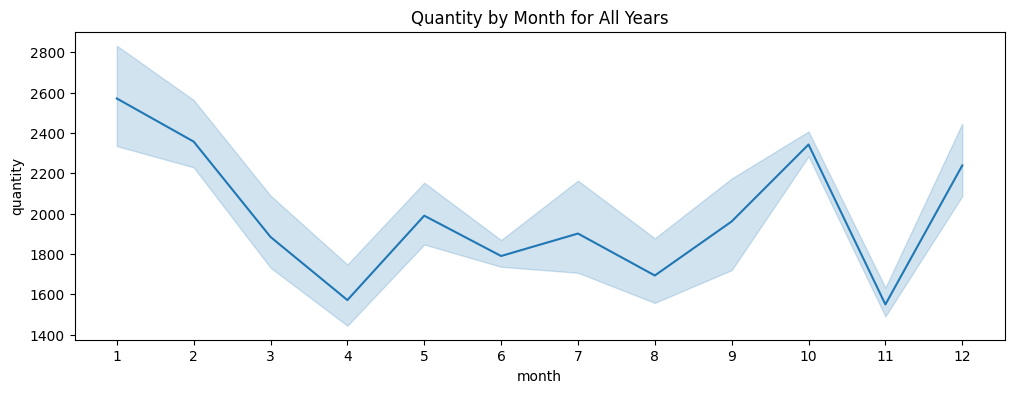

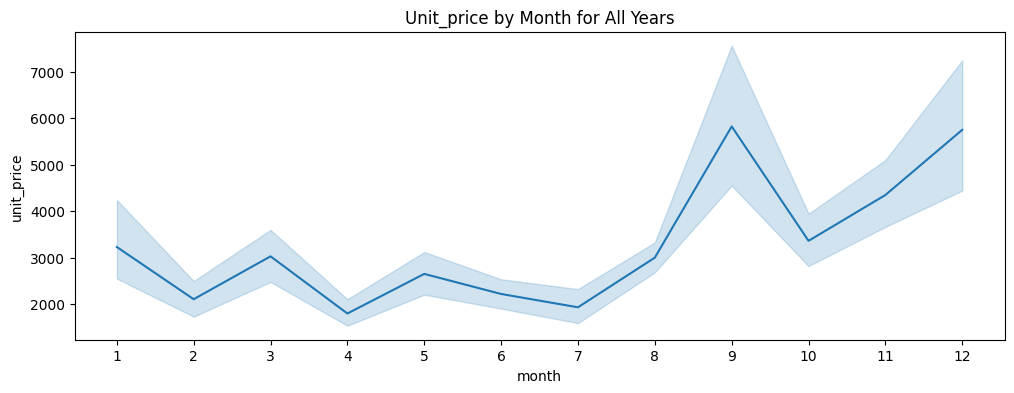

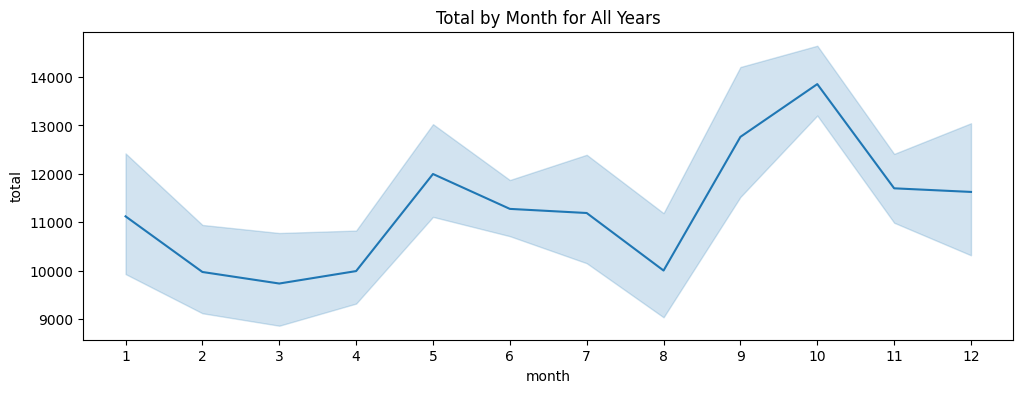

In [ ]:
for col in columns_of_interest:
  plt.figure(figsize=(12, 4))
  sns.lineplot(data=df_sub, x='month', y=col)
  plt.title(f'{col.capitalize()} by Month for All Years')
  plt.xticks(range(1,13))
  plt.show()
  print()

In [ ]:
import numpy as np

def plot_polar_aggregation(df, columns_of_interest, plotfunc='count'):
    """
    Generates and displays a polar plot for aggregated data from a DataFrame.

    This function groups the input DataFrame by month and calculates a specified
    aggregation (count, mean, or median) for the given columns. It then
    creates a polar plot for each of these columns, visualizing the
    aggregated data.

    Args:
        df (pd.DataFrame): The input DataFrame. It must contain a 'month'
            column and the columns specified in `columns_of_interest`.
        columns_of_interest (list of str): A list of column names for which to
            generate the plots.
        plotfunc (str, optional): The aggregation function to use.
            Can be 'count', 'mean', or 'median'. Defaults to 'count'.
    """
    # Define month labels for the angular axis
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    for col in columns_of_interest:
        # --- 1. AGGREGATE DATA ---
        monthly = df.groupby('month')[col]

        if plotfunc == 'mean':
            monthly = monthly.mean().reset_index().sort_values('month')
        elif plotfunc == 'median':
            monthly = monthly.median().reset_index().sort_values('month')
        elif plotfunc == 'count':
            monthly = monthly.count().reset_index().sort_values('month')

        # --- 2. PREPARE DATA FOR PLOTTING ---
        values = monthly[col].values
        angles = np.linspace(0, 2 * np.pi, 12, endpoint=False)

        # Close the loop for a continuous plot
        values_closed = np.concatenate((values, [values[0]]))
        angles_closed = np.concatenate((angles, [angles[0]]))

        # --- 3. CREATE AND CUSTOMIZE THE PLOT ---
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

        ax.plot(angles_closed, values_closed, linewidth=2, linestyle='solid', label=f'{plotfunc.capitalize()} {col.capitalize()}')
        ax.fill(angles_closed, values_closed, alpha=0.25)

        ax.set_theta_direction(-1)
        ax.set_theta_zero_location('N')

        ax.set_xticks(angles)
        ax.set_xticklabels(month_names, fontsize=12)

        if plotfunc == 'count':
          ax.set_title(f'Count by Month', fontsize=16, pad=20)
        else:
          ax.set_title(f'{col.capitalize()} {plotfunc.capitalize()} by Month', fontsize=16, pad=20)

        min_val = monthly[col].min()
        max_val = monthly[col].max()
        ax.set_rlim(min_val * 0.9, max_val * 1.1)

        plt.show()

        if plotfunc == 'count':
            break

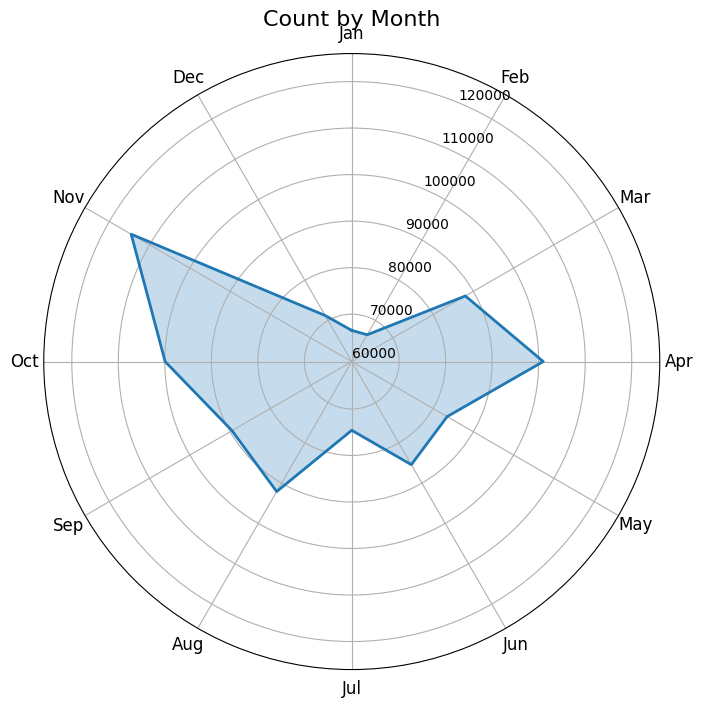

In [ ]:
plot_polar_aggregation(df, columns_of_interest, 'count')

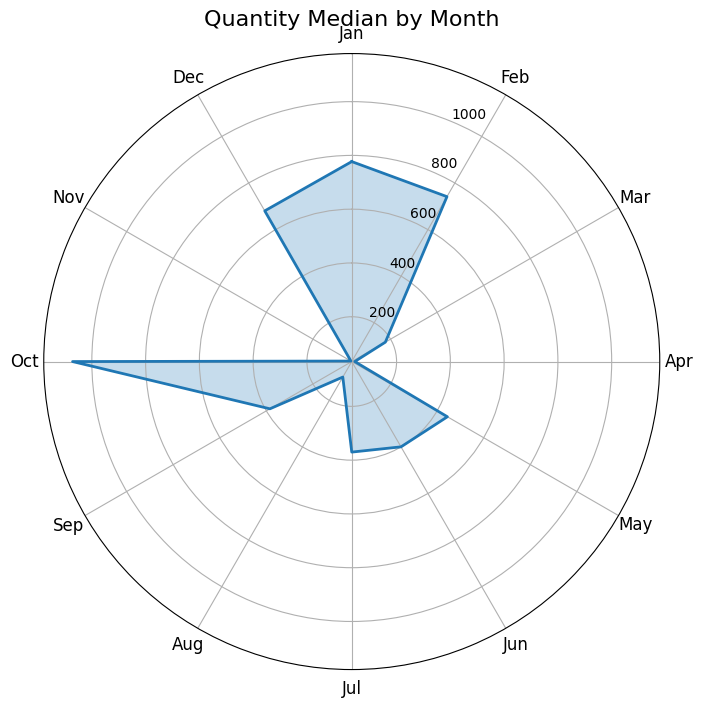

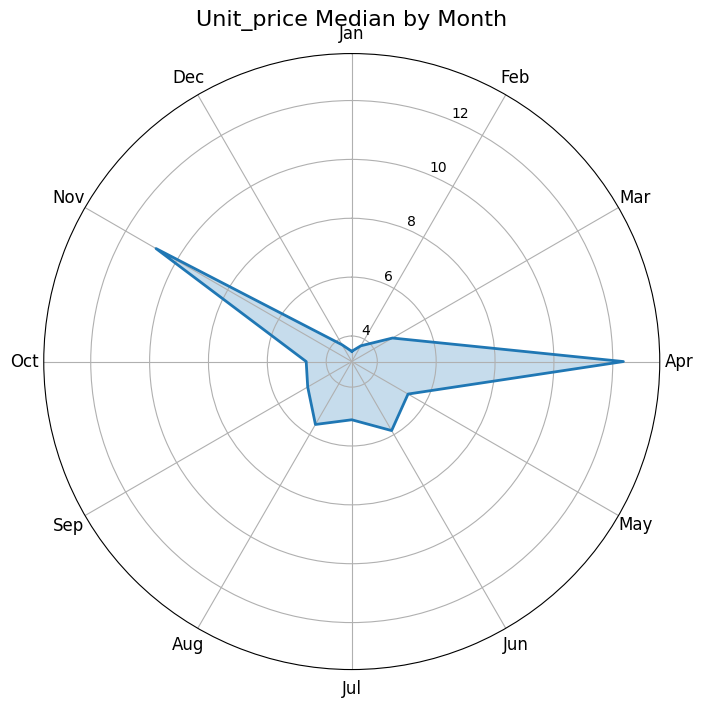

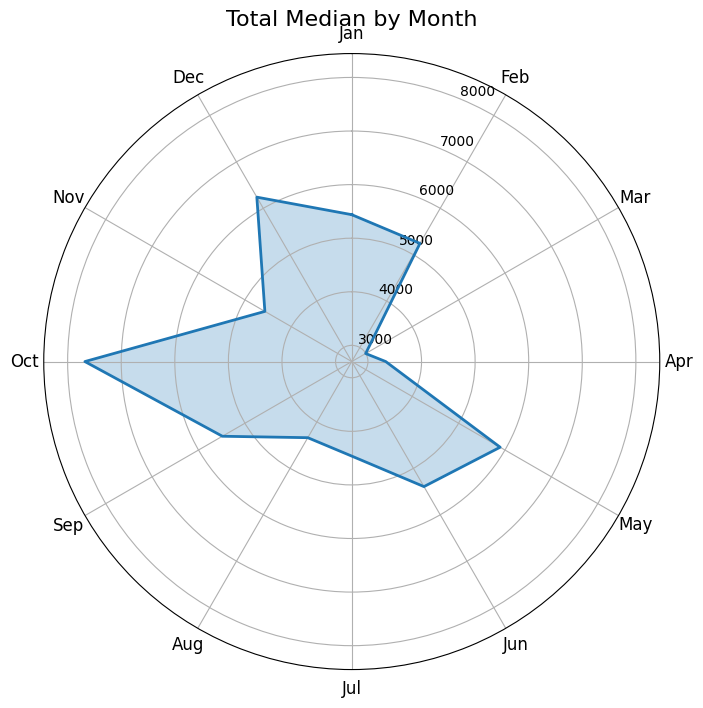

In [ ]:
plot_polar_aggregation(df, columns_of_interest, 'median')

### Plotting Counts by Month Sales and Returns

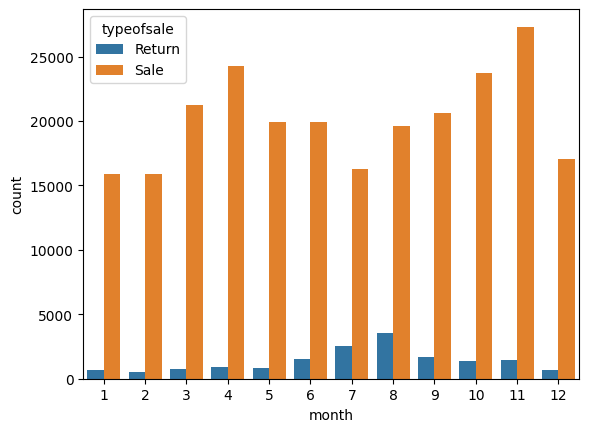

In [ ]:
sns.countplot(data=df_sub,  x = 'month', hue = 'typeofsale')
plt.show()

## Average Total by Month by Product Group

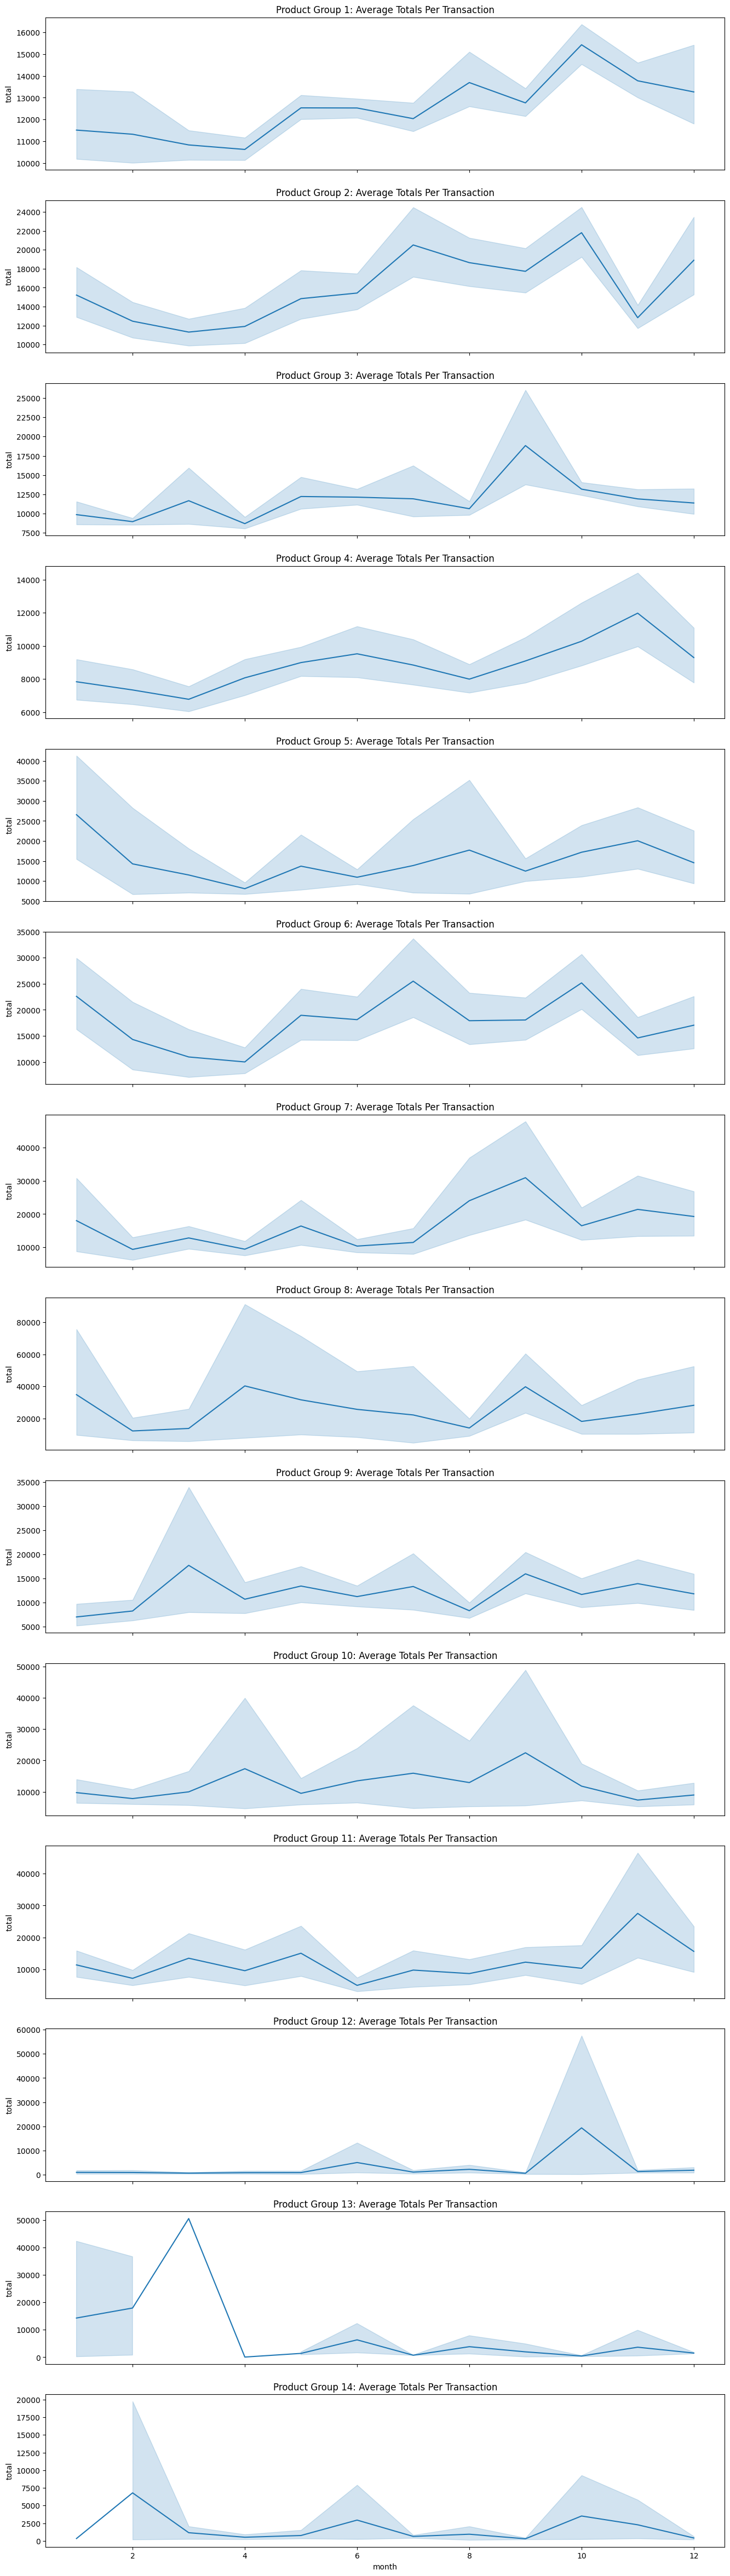

In [ ]:
# Get the unique years from the DataFrame
pgroups = df.productgroup.unique()

# Create a figure and a set of subplots
# nrows is the number of rows, which is the number of unique product groups
# sharey=True ensures that all subplots share the same y-axis scale
fig, axes = plt.subplots(nrows=len(pgroups), ncols=1, figsize=(16, 60), sharex=True) #, sharey=True)

# Loop through the years and the axes to create a plot for each year
for i, product in enumerate(pgroups):
  sns.lineplot(data=df_sub_sale[df_sub_sale['productgroup'] == product], x='month', y='total', ax=axes[i])
  #axes[i].set_yscale('log')
  axes[i].set_title(f'Product Group {product}: Average Totals Per Transaction')

# Show the plots
plt.show()

## Total Sales by Year by Month

In [ ]:
# Get the unique years from the DataFrame
years = sorted(df.year.unique())

# Create a figure and a set of subplots
# nrows is the number of rows, which is the number of unique years
# sharey=True ensures that all subplots share the same y-axis scale
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 8), sharey=True, sharex=True)

# Loop through the years and the axes to create a plot for each year
for i, year in enumerate(years):
  sns.lineplot(data=df[(df['year'] == year) & (df['typeofsale'] == 'Sale')], x='month', y='total', ax=axes[i])
  axes[i].set_title(f'Average Total per Transaction for {year}')

# Adjust the layout to prevent titles and labels from overlapping
plt.tight_layout()
plt.xticks(range(1,13))

# Show the plots
plt.show()

In [ ]:
from matplotlib.ticker import FuncFormatter


df_temp = df[df.typeofsale == 'Sale']
df_temp = df_temp.groupby(['year', 'month'])['total'].sum().reset_index()

# Create a figure and a set of subplots
fig, axes = plt.subplots(nrows=len(years), ncols=1, figsize=(10, 8), sharey=True, sharex=True)

# This function takes the tick value (x) and its position (pos)
# It divides the value by 1,000,000 and formats it as a string with "M"
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

# Loop through the years and the axes to create a plot for each year
for i, year in enumerate(years):
  sns.lineplot(data=df_temp[df_temp.year == year], x='month', y='total', ax=axes[i]) # Filter data for each year
  axes[i].set_title(f'Total Sales for {year}')

  # --- NEW: Apply the formatter to the y-axis of each subplot ---
  axes[i].yaxis.set_major_formatter(FuncFormatter(millions_formatter))
  axes[i].set_ylabel('Total Sales') # Set individual y-axis label
  axes[i].set_xlabel('Month') # Set individual x-axis label


# Adjust the layout to prevent titles and labels from overlapping
plt.tight_layout()
plt.xticks(range(1,13))

# Show the plots
plt.show()

In [ ]:
import plotly.express as px

# Combine product groups 4 and higher into a single category '4+'
df['productgroup_combined'] = df['productgroup'].apply(lambda x: '4+' if x >= 4 else str(x))

# Calculate total sales by the combined product group
sales_by_product_group_combined = df[df['typeofsale'] == 'Sale'].groupby('productgroup_combined')['total'].sum().reset_index()

# Create a donut plot using Plotly
fig = px.pie(sales_by_product_group_combined,
             values='total',
             names='productgroup_combined',
             title='Total Sales by Combined Product Group (1, 2, 3, and 4+)',
             hole=0.5) # 'hole' parameter creates the donut chart

# Update layout to order by label and add text labels to the donut
fig.update_traces(sort=False, textinfo='percent+label')#, insidetextorientation='radial') # Modified: Added sort=False and textinfo/insidetextorientation

fig.show()

In [ ]:
from matplotlib.ticker import FuncFormatter

# This function takes the tick value (x) and its position (pos)
# It divides the value by 1,000,000 and formats it as a string with "M"
def millions_formatter(x, pos):
    return f'{x / 1e6:.1f}M'

for unit in df.unitofmeasure.value_counts().head(6).index:
  plt.figure() # create a new figure for each plot
  ax = sns.barplot(data = df[df.unitofmeasure == unit], x= 'productgroup', y='total', hue='year', estimator=sum, errorbar=None)
  ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter)) # Apply the formatter
  plt.title(f'Total Sales by Product Group and Year for Unit of Measure: {unit}')
  plt.xlabel('Product Group') # Add x-axis label
  plt.ylabel('Total Sales (Millions)') # Add y-axis label
  plt.show()
  print()

In [ ]:
group1_mask = df_sub.loc[:,'productgroup'] == 1

group1df = df_sub.loc[group1_mask]

sns.barplot(x = 'total', y = 'month', data = group1df, hue = 'typeofsale')

plt.title('Group 1 Sales vs Returns')
plt.xlabel('Total USD')
plt.ylabel('Month')


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x79b7ee030cc0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x79b7ee1f2200> (for post_execute):


In [ ]:
group1_cmask = df.loc[:,'productgroup'] == 1

group1_cdf = df.loc[group1_cmask]

sns.barplot(x = month)